In [137]:
import numpy as np

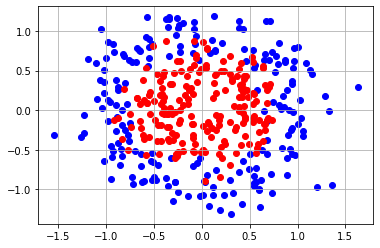

In [138]:
from sklearn.datasets import make_circles
X, y = make_circles(n_samples = 400, noise=0.2, factor=0.5, random_state=1)

def plot(X, y):
    fig, ax = plt.subplots()
    ax.scatter(X[y == 0, 0], X[y == 0, 1], c='blue')
    ax.scatter(X[y == 1, 0], X[y == 1, 1], c='red')
    ax.grid(True)
    plt.show()

plot(X, y)

In [139]:
class DecisionTree:
    
    class TreeNode:
        def __init__(self, div_dim, div_value, left, right):
            self.div_dim = div_dim
            self.div_value = div_value
            self.left = left;
            self.right = right;        
        def apply(self, x):
            if x[self.div_dim] > self.div_value:
                return self.right.apply(x)
            else:
                return self.left.apply(x)            
        def __repr__(self):
            return  "Node: divide x[" + str(self.div_dim) + "] at " + str(self.div_value)
        def print_node(self, indent, prev_div_res):
            return '   ' * indent + ' ' + prev_div_res + ' ' + repr(self) + '\n' + \
                   self.left.print_node(indent+1, '<') + self.right.print_node(indent+1, '>')
            
    class LeafTreeNode(TreeNode):
        def __init__(self, value):
            self.value = value
        def apply(self, x):
            return self.value
        def __repr__(self):
            return "Leaf Node: " + str(self.value)
        def print_node(self, indent, prev_div_res):
            return '   ' * indent + ' ' + prev_div_res + ' ' + repr(self) + '\n'
    
    def __init__(self, max_depth = 3):
        if max_depth < 1:
            raise ValueError("max_depth needs to be positive")
        self.root = None
        self.max_depth = max_depth
        
    def predict(self, inp):
        if self.root == None:
            print("Decision Tree not initialized.")
            return None
        return [self.root.apply(single_inp) for single_inp in inp]
        
    def _info_gain_divide_func(self, X, y):
        """Find the best value to divide the given feature/label pair.

        Args:
          X: a (1, n) shape input feature vector
          y: a (1, n) shape input label vector

        Returns:
          info_gain: the information gain under best split
          best_div_value: the best value to divide the feature vector
        """
        def compute_info(y):
            """Compute the information entropy.

            Args:
              y: a (1, n) shape input vector with only 0 or 1 value
            """
            p1 = sum(y) / len(y)
            p2 = 1 - p1
            if p1 == 0 or p2 == 0:
                return 0.
            return -1 * (p1*np.log2(p1) + p2*np.log2(p2))
        
        curr_info = compute_info(y)
        
        xy = np.array(sorted([[X[i], y[i]] for i in range(len(y))]))
        best_div_pos, min_info = None, None
        for div_pos in range(1, len(xy)):
            l_info = compute_info(xy[:div_pos, 1]) 
            r_info = compute_info(xy[div_pos:, 1])
            
            l_ratio = div_pos / len(xy)
            r_ratio = 1 - l_ratio
            
            div_info = l_ratio * l_info + r_ratio * r_info
            
            if min_info == None or min_info > div_info:
                best_div_pos = div_pos
                min_info = div_info
                
        best_div_value = (xy[best_div_pos-1][0] + xy[best_div_pos][0]) / 2
        info_gain = curr_info - min_info
        
        return info_gain, best_div_value
    
    def fit(self, X, y):
        self.root = self._fit_helper(X, y, self.max_depth)
    
    def _fit_helper(self, X, y, max_depth):
        if sum(y) == len(y):
            return DecisionTree.LeafTreeNode(True)
        elif sum(y) == 0:
            return DecisionTree.LeafTreeNode(False)
        
        if max_depth == 1:
            return DecisionTree.LeafTreeNode(sum(y) / len(y) > 0.5)
        
        best_dim, best_div_value, largest_info_gain= None, None, None
        for dim_idx in range(len(X[0])):
            info_gain, div_value = self._info_gain_divide_func(X[:, dim_idx], y)
            if largest_info_gain == None or info_gain > largest_info_gain:
                best_dim = dim_idx
                best_div_value = div_value
                largest_info_gain = info_gain

        split_res = [x[best_dim] > best_div_value for x in X]
        right_node = self._fit_helper(X[split_res], y[split_res], max_depth - 1)
        left_node = self._fit_helper(X[np.invert(split_res)], y[np.invert(split_res)], max_depth - 1)

        return DecisionTree.TreeNode(best_dim, best_div_value, left_node, right_node)
    
    def print_tree(self):
        print('DecisionTree: ' + 'max_depth=' + str(self.max_depth))
        print(self.root.print_node(0, '-'))
    
    
dt = DecisionTree(max_depth=4)
dt.fit(X, y)
dt.print_tree()
print('accuracy: ', sum(dt.predict(X) == y) / len(y))

DecisionTree: max_depth=4
 - Node: divide x[1] at -0.6056278153732871
    < Node: divide x[1] at -0.8957587437777383
       < Leaf Node: False
       > Node: divide x[1] at -0.8896407075859523
          < Leaf Node: True
          > Leaf Node: False
    > Node: divide x[0] at 0.7332449607611186
       < Node: divide x[1] at 0.6274491525873669
          < Leaf Node: True
          > Leaf Node: False
       > Leaf Node: False

accuracy:  0.8425
